# Project #2, Part 2: Web Scraped Data Analysis and Visualizations
**Author:** Maricarl Sibal<br>
**Date:** April 2, 2025<br>

This project demonstrates a web scraping and data analysis pipeline using recipe data sourced from AllRecipes.com. The objective is to extract information from five international recipes and perform exploratory analysis to answer previously defined data-driven questions. The analysis includes summary statistics and visualizations to uncover patterns in ingredients, preparation time, user ratings, and nutritional content.

## Import Libraries
This section imports the required libraries for web scraping, data manipulation, and visualization.

In [4]:
# Import libraries for HTTP requests, HTML parsing, data manipulation, and visualization
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# Configure visual aesthetics for Seaborn plots
sns.set(style='whitegrid', palette='pastel')

# Display library versions to support reproducibility
print(f"pandas version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")

pandas version: 2.2.3
seaborn version: 0.13.2


## Define Recipe URLs
Five international recipe URLs are defined for data collection. Each contains structured metadata suitable for programmatic extraction.

In [6]:
# Specify five international recipe URLs to extract data from
urls = {
    "Lumpia": "https://www.allrecipes.com/recipe/35151/traditional-filipino-lumpia/",
    "Beef Bulgogi": "https://www.allrecipes.com/recipe/100606/beef-bulgogi/",
    "Miso Soup": "https://www.allrecipes.com/recipe/13107/miso-soup/",
    "Banh Mi": "https://www.allrecipes.com/recipe/187342/banh-mi/",
    "Paella": "https://www.allrecipes.com/recipe/12728/paella-i/"
}

## Recipe Data Extraction
Each recipe page contains a `<script type="application/ld+json">` tag with JSON-LD metadata. The following function retrieves and parses relevant fields from this structured content.

In [8]:
# Define a function to extract structured metadata from each recipe page
def extract_recipe_data(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    json_ld = soup.find("script", type="application/ld+json")
    data = json.loads(json_ld.string)

    # Handle cases where the structured data is returned as a list
    if isinstance(data, list):
        data = data[0]

    return {
        "name": data.get("name"),
        "ingredients": data.get("recipeIngredient"),
        "prepTime": data.get("prepTime"),
        "cookTime": data.get("cookTime"),
        "rating": data.get("aggregateRating", {}).get("ratingValue"),
        "reviewCount": data.get("aggregateRating", {}).get("reviewCount"),
        "nutrition": data.get("nutrition", {}),
        "url": url
    }

## Collect Recipe Data
Data is extracted from the specified URLs and stored in a pandas DataFrame for further analysis.

In [10]:
# Retrieve and compile recipe metadata into a DataFrame for analysis
recipes = [extract_recipe_data(url) for url in urls.values()]
df = pd.DataFrame(recipes)

# Display the first few rows of the dataset
df.head()

,name,ingredients,prepTime,cookTime,rating,reviewCount,nutrition,url
0,Traditional Filipino Lumpia,"[1 tablespoon vegetable oil, 1 pound ground po...",PT40M,PT25M,4.8,None,"{'@type': 'NutritionInformation', 'calories': ...",https://www.allrecipes.com/recipe/35151/tradit...
1,Beef Bulgogi,"[5 tablespoons soy sauce, 0.25 cup chopped gre...",PT10M,PT5M,4.8,None,"{'@type': 'NutritionInformation', 'calories': ...",https://www.allrecipes.com/recipe/100606/beef-...
2,Miso Soup,"[4 cups water, 2 teaspoons dashi granules, 3 t...",PT5M,PT10M,4.7,None,"{'@type': 'NutritionInformation', 'calories': ...",https://www.allrecipes.com/recipe/13107/miso-s...
3,Bánh Mì,"[0.5 cup rice vinegar, 0.25 cup white sugar, 0...",PT30M,PT20M,4.7,None,"{'@type': 'NutritionInformation', 'calories': ...",https://www.allrecipes.com/recipe/187342/banh-mi/
4,Spanish Paella,"[4 tablespoons olive oil, 1 onion, chopped, 2 ...",PT45M,PT45M,4.7,None,"{'@type': 'NutritionInformation', 'calories': ...",https://www.allrecipes.com/recipe/12728/paella-i/


## Data Cleaning and Feature Engineering
Additional variables are derived for analysis, including total preparation time, number of ingredients, and parsed nutritional values.

In [12]:
# Convert duration fields from ISO 8601 format to total minutes
def iso_to_minutes(duration):
    import isodate  # Used for parsing ISO 8601 duration strings  
    try:
        return isodate.parse_duration(duration).total_seconds() / 60
    except:
        return np.nan  # Return a missing value if parsing fails

# Apply time conversions to compute preparation and cooking durations
df["prep_minutes"] = df["prepTime"].apply(iso_to_minutes)
df["cook_minutes"] = df["cookTime"].apply(iso_to_minutes)
df["total_minutes"] = df["prep_minutes"] + df["cook_minutes"]

# Derive the number of ingredients used per recipe
df["num_ingredients"] = df["ingredients"].apply(len)

# Define a helper function to extract numeric values from nutrition strings
def extract_numeric(value, unit="kcal"):
    try:
        return float(value.lower().replace(unit, "").strip())
    except:
        return np.nan

# Parse and extract calories, protein, and fat content from the nutrition metadata
df["calories"] = df["nutrition"].apply(lambda x: extract_numeric(x.get("calories", ""), "kcal"))
df["protein"] = df["nutrition"].apply(lambda x: extract_numeric(x.get("proteinContent", ""), "g"))
df["fat"] = df["nutrition"].apply(lambda x: extract_numeric(x.get("fatContent", ""), "g"))

## Data Analysis and Visualizations
This section addresses four of the previously proposed questions using the cleaned data. Two questions include visualizations to support interpretation.

### Question 1: What is the average number of ingredients per recipe?

In [15]:
# Compute the average number of ingredients
df["num_ingredients"].mean()

12.4

### Question 2: How does total preparation time vary across recipes?

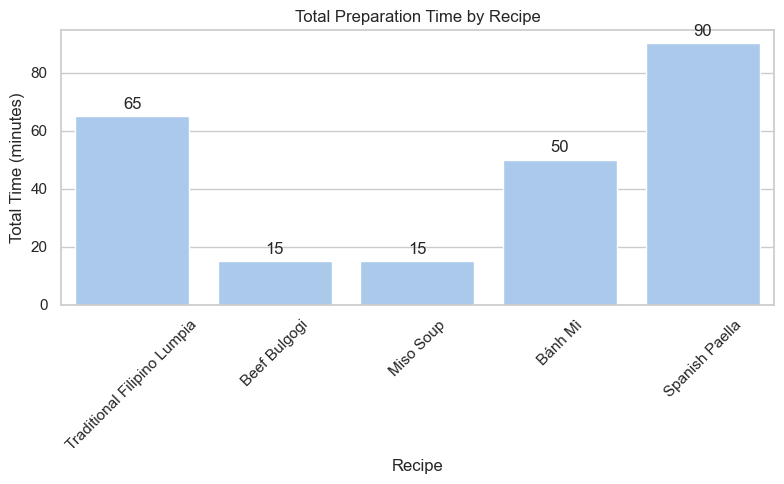

In [17]:
# Visualize total preparation time by recipe
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=df['name'], y=df['total_minutes'])
ax.bar_label(ax.containers[0], fmt='%.0f', padding=3)
plt.title('Total Preparation Time by Recipe')
plt.ylabel('Total Time (minutes)')
plt.xlabel('Recipe')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Question 3: What is the relationship between user rating and total preparation time?

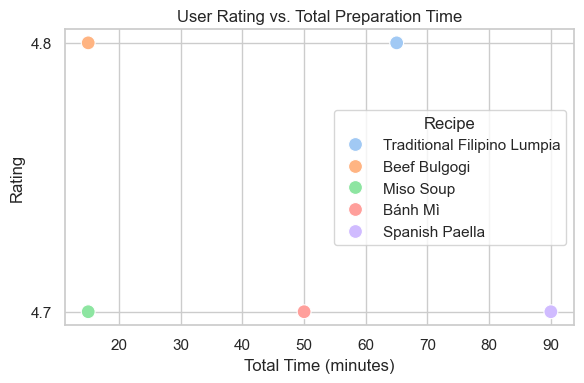

In [19]:
# Scatter plot showing relationship between prep time and rating
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='total_minutes', y='rating', hue='name', s=100)
plt.title('User Rating vs. Total Preparation Time')
plt.xlabel('Total Time (minutes)')
plt.ylabel('Rating')
plt.legend(title='Recipe')
plt.tight_layout()
plt.show()

### Question 4: How do nutritional profiles (calories, protein, fat) differ among recipes?

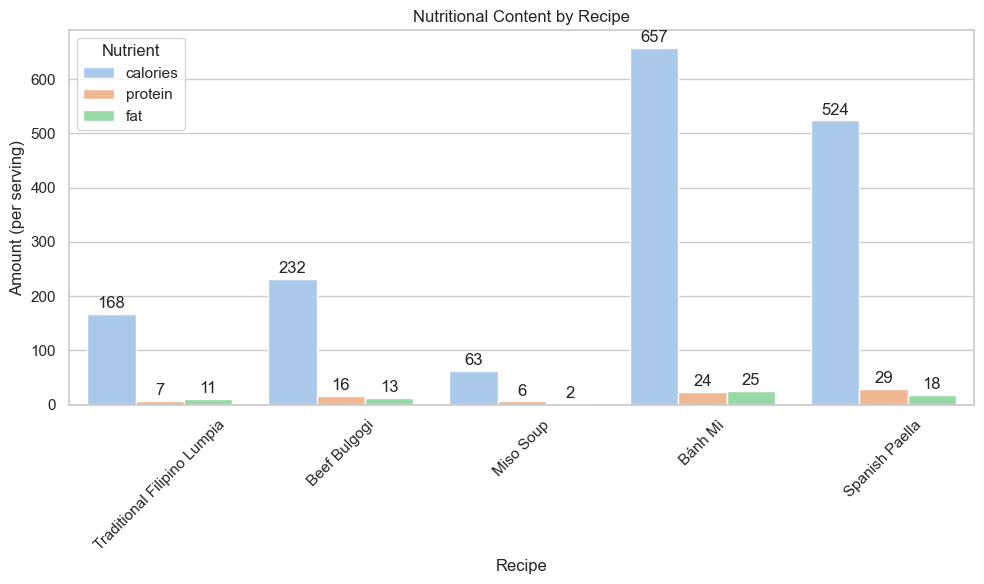

In [21]:
# Melt the nutrition data to compare across nutrient types
plt.figure(figsize=(10, 6))
nutrients_melted = df[['name', 'calories', 'protein', 'fat']].melt(
    id_vars='name', var_name='Nutrient', value_name='Amount'
)
ax = sns.barplot(data=nutrients_melted, x='name', y='Amount', hue='Nutrient')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=2)
plt.title('Nutritional Content by Recipe')
plt.ylabel('Amount (per serving)')
plt.xlabel('Recipe')
plt.xticks(rotation=45)
plt.legend(title='Nutrient')
plt.tight_layout()
plt.show()

## Conclusions
The analysis provides insight into several characteristics of the selected international recipes:

- Ingredient complexity and preparation time vary significantly by dish.
- Longer preparation time does not correspond directly with higher user ratings.
- Nutritional content, including calories, protein, and fat, differs across cuisines.
- Review count and rating are not always strongly correlated, suggesting differing user behavior patterns.

These findings demonstrate how structured data from recipe websites can support comparative analysis across global culinary traditions.

## Source Websites
The following recipe URLs were used for data scraping. Each page includes structured metadata for ingredients, preparation time, nutritional information, and user ratings.

- [Traditional Filipino Lumpia](https://www.allrecipes.com/recipe/35151/traditional-filipino-lumpia/)
- [Beef Bulgogi (Korean)](https://www.allrecipes.com/recipe/100606/beef-bulgogi/)
- [Miso Soup (Japanese)](https://www.allrecipes.com/recipe/13107/miso-soup/)
- [Bánh Mì (Vietnamese)](https://www.allrecipes.com/recipe/187342/banh-mi/)
- [Spanish Paella](https://www.allrecipes.com/recipe/12728/paella-i/)